In [1]:
import torch.nn as nn
import torch.nn.parallel

from torch.utils.data import DataLoader
from Models import MNIST_classifier

import os
import numpy as np
from mnist_prepare_subset_select_train_val_test import MNIST

import torch.optim as optim
from torch.optim import lr_scheduler
# import torchvision
import torchvision.transforms as transforms
from termcolor import cprint
# from knn_utils import calc_knn_graph, calc_topo_weights_with_components_idx
from noise import noisify_with_P, noisify_cifar10_asymmetric, noisify_cifar100_asymmetric, noisify_pairflip, noisify_modelnet40_asymmetric
import copy
from scipy.stats import mode
from matplotlib import pyplot as plt
import torch.nn.functional as F

from subset_select_ipot_non_uniform_git import subset_select_ipot as ss_ipot

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"


# Noisy Data Set

In [2]:
# def _init_fn(worker_id):
#     np.random.seed(77 + worker_id)


# # models_path = "G:\\My Drive\\Research Codes\\Subset Selection Paper\\Neural Network Classifier\\models\\UCI-subset-select\\MNIST\\"
# models_path = ""

# train_val_ratio = 0.8
# # trust_prop = 0.5

# batch_size_train = 512

# num_classes = 10
# max_epochs = 100

# # noise_level = 0.8

# c = 20
# trust_props = [0.2, 0.4, 0.6, 0.8]
# noise_levels = [0.2, 0.4, 0.6, 0.8]

# for trust_prop in trust_props:
#     for noise_level in noise_levels:
        
#         print("trust_prop=",trust_prop)
#         print("noise_level=",noise_level)
#         torch.manual_seed(77)

#         transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
#         trainset = MNIST(root='./data', split='train', train_ratio=train_val_ratio,trust_prop=trust_prop,  download=True, transform=transform_train)
#         trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=0, worker_init_fn=_init_fn)

#         random_seed = 42
#         noise_y_train_labels0, noise_y_train_indices = trainset.get_noisy_labels_with_indices()
#         noise_y_train, p, _ = noisify_with_P(noise_y_train_labels0, nb_classes=num_classes, noise=noise_level, random_state=random_seed)
#         trainset.update_corrupted_label(noise_y_train, noise_y_train_indices)

#         valset = MNIST(root='./data', split='val', train_ratio=train_val_ratio, trust_prop=trust_prop, download=True, transform=transform_train)
#         valloader = torch.utils.data.DataLoader(valset, batch_size=512, shuffle=False, num_workers=0)

#         testset = MNIST(root='./data', split='test', download=True, transform=transform_train)
#         testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=0)

        
#         unique_labels = [int(i) for i in list(np.linspace(0, 10, 10, endpoint=False))]
#         torch.manual_seed(0)

#         net = MNIST_classifier().to(device)
#         criterion = nn.CrossEntropyLoss(reduction='mean')
#         optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)

#         train_acc = []
#         val_acc = []
#         best_accuracy = 0

#         for epoch in range(max_epochs):  # loop over the dataset multiple times
#             running_loss = []
#             for i, data in enumerate(trainloader, 0):
#                 # get the inputs; data is a list of [inputs, labels]
#                 # _, images, labels, _, _ = data
#                 images, labels, _, _, _ = data
#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward + backward + optimize
#                 outputs, _ = net(images.double().to(device))
#                 loss = criterion(outputs, labels.long().to(device))
#                 loss.backward()
#                 optimizer.step()

#                 running_loss.append(loss.item())
#                 # avg_loss.append(torch.tensor(running_loss).mean())
#             print("epoch={0:d},  avg_loss = {1:0.4f}".format(
#                 epoch, torch.tensor(running_loss).mean()))

#             if True:
#                 classes = tuple([str(i) for i in unique_labels])
#                 correct_pred = {classname: 0 for classname in classes}
#                 total_pred = {classname: 0 for classname in classes}
#                 total = 0
#                 correct = 0

#                 net.eval()
#                 with torch.no_grad():
#                     for data in valloader:
#                         images, labels, _, _, _ = data
#                         outputs, _ = net(images.double().to(device))
#                         _, predictions = torch.max(outputs, dim=1)
#                         total += labels.size(0)
#                         correct += (predictions.cpu() == labels).sum().item()
#                     print(f'val set accuraccy: {100 * correct / total} %')
#                     val_acc.append(100 * correct / total)

#                 if val_acc[-1] > best_accuracy:
#                     best_accuracy = val_acc[-1]
#                     net_path = models_path + "MNIST_noisy"+"trust_prop={trust_prop:0.2f}".format(
#                         trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
#                     torch.save({
#                         'epoch': epoch,
#                         'model_state_dict': net.state_dict(),
#                         'optimizer_state_dict': optimizer.state_dict(),
#                         'val-accuracy': val_acc,
#                         'train-accuracy': train_acc}, net_path)

#                 classes = tuple([str(i) for i in unique_labels])
#                 correct_pred = {classname: 0 for classname in classes}
#                 total_pred = {classname: 0 for classname in classes}
#                 total = 0
#                 correct = 0
#                 net.eval()
#                 with torch.no_grad():
#                     for data in trainloader:
#                         images, labels, _, _, _ = data
#                         outputs, _ = net(images.double().to(device))
#                         _, predictions = torch.max(outputs, dim=1)
#                         total += labels.size(0)
#                         correct += (predictions.cpu() == labels).sum().item()
#                 print(f'train set accuracy: {100 * correct / total} %')
#                 train_acc.append(100 * correct / total)


#         print('Finished Training')
#         # saving training accuracy list along with model with best accuracy
#         net_path = models_path + "MNIST_noisy"+"trust_prop={trust_prop:0.2f}".format(
#             trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
#         best_net_dict = torch.load(net_path)
#         best_net_dict['val-accuracy'] = val_acc
#         best_net_dict['train-accuracy'] = train_acc
#         torch.save(best_net_dict, net_path)


test set accuraccy: 97.35 %
test set accuraccy: 96.59 %
test set accuraccy: 95.61 %
test set accuraccy: 94.0 %
test set accuraccy: 97.56 %
test set accuraccy: 97.25 %
test set accuraccy: 96.41 %
test set accuraccy: 95.87 %
test set accuraccy: 97.77 %
test set accuraccy: 97.56 %
test set accuraccy: 97.14 %
test set accuraccy: 97.15 %
test set accuraccy: 97.77 %
test set accuraccy: 97.52 %
test set accuraccy: 97.53 %
test set accuraccy: 97.43 %


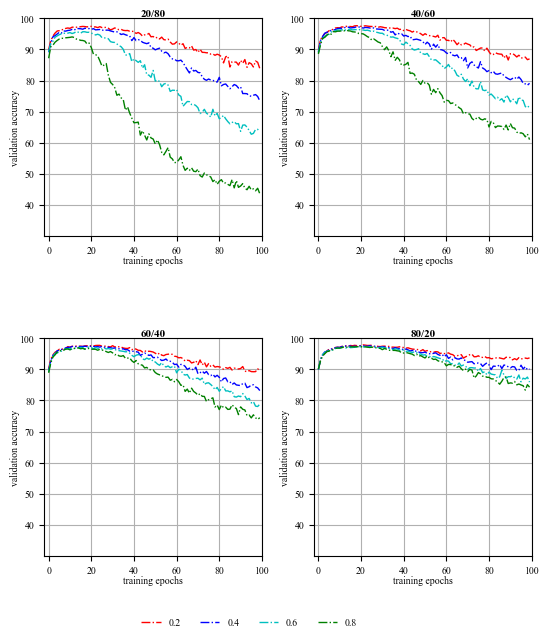

In [14]:
import pandas as pd
import matplotlib
font = {'family': 'Times New Roman',
        'size': 7}
font1 = {'family': 'Times New Roman',
         'size': 7}

matplotlib.rc('font', **font)

trust_props = [0.2, 0.4, 0.6, 0.8]
noise_levels = [0.2, 0.4, 0.6, 0.8]
max_epochs = 100
fig, axs = plt.subplots(2, 2, figsize=(5.5, 6.6), tight_layout=True)

max_val_accs = np.zeros([len(trust_props), len(noise_levels)])
max_test_accs = np.zeros([len(trust_props), len(noise_levels)])

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

testset = MNIST(root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=0)
unique_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# G: \My Drive\Research Codes\Subset Selection Paper\Neural Network Classifier\USPS\CIFAR10\test on noisy data\Lambda tests\ss_1 cifar10 c = 20trust_prop = 0.40noise_level = 0.20.pth

models_path = ""

line_colors = ['r', 'b', 'c', 'g']
for i in range(len(trust_props)):
    for j in range(len(noise_levels)):
        trust_prop = trust_props[i]
        noise_level = noise_levels[j]
        net_path = models_path + "MNIST_noisy"+"trust_prop={trust_prop:0.2f}".format(
            trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
        best_net_dict = torch.load(net_path)
        net = MNIST_classifier().to(device)
        net.load_state_dict(best_net_dict['model_state_dict'])

        classes = tuple([str(i) for i in unique_labels])
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}
        total = 0
        correct = 0

        net.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels, _, _, _ = data
                outputs, _ = net(images.double().to(device))
                _, predictions = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predictions.cpu() == labels).sum().item()
            print(f'test set accuraccy: {100 * correct / total} %')
        max_test_accs[i, j] = 100 * correct / total

        acc_ci = best_net_dict["val-accuracy"]
        max_val_accs[i, j] = max(acc_ci)
        acc_ci = np.array([i/100 for i in acc_ci])
        iters = np.linspace(0, max_epochs, 100, endpoint=False)
        # label_str = "{trust_prop:0.0f}%".format(trust_prop=int(100*trust_prop)) + " {noise_level:0.1f}".format(noise_level=noise_level)
        label_str = "{noise_level:0.1f}".format(noise_level=noise_level)
        if i != len(trust_props)-1:
            axs.flatten()[i].plot(iters, 100*acc_ci,
                                  color=line_colors[j], linestyle="-.", linewidth=1.0)
        else:
            axs.flatten()[i].plot(iters, 100*acc_ci, color=line_colors[j],
                                  linestyle="-.", label=label_str, linewidth=1.0)

    title_str = str(int(100*trust_prop)) + "/" + str(int(100 - 100*trust_prop))
    axs.flatten()[i].set_title(title_str, font={
        'weight': 'bold', 'size': 8}, pad=0)
    axs.flatten()[i].set_xlabel("training epochs", labelpad=0.01, **font)
    axs.flatten()[i].set_ylabel("validation accuracy", labelpad=0.01, **font)
    axs.flatten()[i].set_xlim([-2, 100])
    axs.flatten()[i].set_yticks([40, 50, 60, 70, 80, 90, 100])
    axs.flatten()[i].set_ylim([30, 100])
    axs.flatten()[i].grid()
    axs.flatten()[i].set_box_aspect(1)
    # axs.flatten()[i].legend(ncol=1, prop =font1)
fig.legend(loc=(0.25, 0.001), prop=font1, ncol=4, frameon=False)
# fig.tight_layout()
max_val_accs_df = pd.DataFrame(max_val_accs, index=[int(100*i) for i in trust_props], columns=noise_levels)
max_test_accs_df = pd.DataFrame(max_test_accs, index=[int(100*i) for i in trust_props], columns=noise_levels)


In [15]:
max_test_accs_df

,0.2,0.4,0.6,0.8
20,97.35,96.59,95.61,94.00
40,97.56,97.25,96.41,95.87
60,97.77,97.56,97.14,97.15
80,97.77,97.52,97.53,97.43


In [16]:
max_val_accs_df

,0.2,0.4,0.6,0.8
20,97.416667,96.825000,95.766667,94.025000
40,97.633333,97.341667,96.533333,96.225000
60,97.716667,97.525000,97.125000,96.900000
80,97.883333,97.608333,97.358333,97.308333


# Subset Select

In [5]:
# def _init_fn(worker_id):
#     np.random.seed(77 + worker_id)


# # models_path = "G:\\My Drive\\Research Codes\\Subset Selection Paper\\Neural Network Classifier\\models\\UCI-subset-select\\MNIST\\"
# models_path = ""

# train_val_ratio = 0.8
# trust_prop = 0.5
# batch_size_train = 512
# num_classes = 10
# noise_level = 0.8
# # cs = [1, 2, 3, 4, 5, 6, 7, 8, 20]
# c = 20
# max_epochs = 100
# gamma_ss = 0.01

# trust_props = [0.2, 0.4, 0.6, 0.8]
# noise_levels = [0.2, 0.4, 0.6, 0.8]

# # models_path + "ss_1 " +  "cifar10 " + "c={cs:2d}".format(cs=c)+".pth"

# for trust_prop in trust_props:
#     for noise_level in noise_levels:

#         print("trust_prop=", trust_prop)
#         print("noise_level=", noise_level)
    
#         torch.manual_seed(42)

#         transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
#         trainset = MNIST(root='./data', split='train', train_ratio=train_val_ratio,trust_prop=trust_prop,  download=True, transform=transform_train)
#         trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=0, worker_init_fn=_init_fn)
        
#         random_seed = 42    
#         noise_y_train_labels0, noise_y_train_indices = trainset.get_noisy_labels_with_indices()
#         noise_y_train, p, _ = noisify_with_P(noise_y_train_labels0, nb_classes=num_classes, noise=noise_level, random_state=random_seed)
#         trainset.update_corrupted_label(noise_y_train, noise_y_train_indices)

#         valset = MNIST(root='./data', split='val', train_ratio=train_val_ratio,trust_prop=trust_prop, download=True, transform=transform_train)
#         valloader = torch.utils.data.DataLoader(valset, batch_size=512, shuffle=False, num_workers=0)

#         testset = MNIST(root='./data', split='test',download=True, transform=transform_train)
#         testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=0)

        
#         unique_labels = [int(i) for i in list(np.linspace(0, 10, 10, endpoint=False))]
#         torch.manual_seed(0)

#         net = MNIST_classifier().to(device)
#         criterion = nn.CrossEntropyLoss(reduction='mean')
#         optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)

#         train_acc = []
#         val_acc = []
#         best_accuracy = 0

#         for epoch in range(max_epochs):  # loop over the dataset multiple times
#             running_loss = []
#             net.train()
#             for i, data in enumerate(trainloader, 0):
#                 # get the inputs; data is a list of [inputs, labels]
#                 # _, images, labels, _, _ = data
#                 images, labels, weights, cd_y, idx = data
#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward + backward + optimize
#                 outputs, encodings = net(images.double().to(device))


#                 x = encodings[cd_y == 1].detach().cpu()
#                 y = encodings[cd_y == 0].detach().cpu()
#                 x_labels = labels[cd_y == 1].detach().cpu()
#                 y_labels = labels[cd_y == 0].detach().cpu()
#                 x_idx = idx[cd_y == 1].detach().cpu()
#                 y_idx = idx[cd_y == 0].detach().cpu()

#                 x_labels_onehot = (F.one_hot(x_labels.long(), num_classes=num_classes)).to(device).double()

#                 mu = 1/x.shape[0]*np.ones(x.shape[0])
#                 nu = 1/y.shape[0]*np.ones(y.shape[0])
#                 costs, P, _, _ = ss_ipot(x, y, mu, nu, c,  gamma_ss, max_outer_iter=20, max_inner_iter=20, wd=2, disp_iter=False, return_map=True)

#                 P_torch = torch.from_numpy(P).to(device)
#                 y_labels_hat = (P_torch.T@x_labels_onehot.double()).to(device)

#                 input_labels_hat = torch.zeros_like(outputs, device=device, dtype=torch.double)
#                 input_labels_hat[cd_y == 1] = 1 / x.shape[0] * (x_labels_onehot.double())
#                 input_labels_hat[cd_y == 0] = y_labels_hat

#                 loss = - torch.sum(input_labels_hat*F.log_softmax(outputs, dim=1))
#                 loss.backward()
#                 optimizer.step()
#                 running_loss.append(loss.item())
#                 # avg_loss.append(torch.tensor(running_loss).mean())
#             print("epoch={0:d},  avg_loss = {1:0.4f}".format(
#                 epoch, torch.tensor(running_loss).mean()))

#             if True:
#                 classes = tuple([str(i) for i in unique_labels])
#                 correct_pred = {classname: 0 for classname in classes}
#                 total_pred = {classname: 0 for classname in classes}
#                 total = 0
#                 correct = 0

#                 net.eval()
#                 with torch.no_grad():
#                     for data in valloader:
#                         images, labels, _, _, _ = data
#                         outputs, _ = net(images.double().to(device))
#                         _, predictions = torch.max(outputs, dim=1)
#                         total += labels.size(0)
#                         correct += (predictions.cpu() == labels).sum().item()
#                     print(f'val set accuraccy: {100 * correct / total} %')
#                     val_acc.append(100 * correct / total)

#                 if val_acc[-1] > best_accuracy:
#                     best_accuracy = val_acc[-1]
#                     net_path = models_path + "ss_1 " +  "mnist " + "c={cs:2d}".format(cs=c)+"trust_prop={trust_prop:0.2f}".format(trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
#                     torch.save({
#                         'epoch': epoch,
#                         'model_state_dict': net.state_dict(),
#                         'optimizer_state_dict': optimizer.state_dict(),
#                         'val-accuracy': val_acc,
#                         'train-accuracy': train_acc}, net_path)

#                 classes = tuple([str(i) for i in unique_labels])
#                 correct_pred = {classname: 0 for classname in classes}
#                 total_pred = {classname: 0 for classname in classes}
#                 total = 0
#                 correct = 0
#                 net.eval()
#                 with torch.no_grad():
#                     for data in trainloader:
#                         images, labels, _, _, _ = data
#                         outputs, _ = net(images.double().to(device))
#                         _, predictions = torch.max(outputs, dim=1)
#                         total += labels.size(0)
#                         correct += (predictions.cpu() == labels).sum().item()
#                 print(f'train set accuracy: {100 * correct / total} %')
#                 train_acc.append(100 * correct / total)


#         print('Finished Training')
#         # saving training accuracy list along with model with best accuracy
#         net_path = models_path + "ss_1 " + "mnist " + "c={cs:2d}".format(cs=c)+"trust_prop={trust_prop:0.2f}".format(
#             trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
#         best_net_dict = torch.load(net_path)
#         best_net_dict['val-accuracy'] = val_acc
#         best_net_dict['train-accuracy'] = train_acc
#         torch.save(best_net_dict, net_path)

In [ ]:
# from subset_select_ipot_non_uniform_pytorch_git import subset_select_ipot_pytorch as ss_ipot

# def _init_fn(worker_id):
#     np.random.seed(77 + worker_id)


# # models_path = "G:\\My Drive\\Research Codes\\Subset Selection Paper\\Neural Network Classifier\\models\\UCI-subset-select\\MNIST\\"
# models_path = ""

# train_val_ratio = 0.8
# batch_size_train = 512
# num_classes = 10
# noise_level = 0.8
# # cs = [1, 2, 3, 4, 5, 6, 7, 8, 20]
# c = 2
# max_epochs = 100
# gamma_ss = 0.01

# trust_props = [0.2, 0.4, 0.6, 0.8]
# noise_levels = [0.2, 0.4, 0.6, 0.8]

# # models_path + "ss_1 " +  "cifar10 " + "c={cs:2d}".format(cs=c)+".pth"

# for trust_prop in trust_props:
#     for noise_level in noise_levels:

#         print("trust_prop=", trust_prop)
#         print("noise_level=", noise_level)
    
#         torch.manual_seed(42)

#         transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
#         trainset = MNIST(root='./data', split='train', train_ratio=train_val_ratio,trust_prop=trust_prop,  download=True, transform=transform_train)
#         trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=0, worker_init_fn=_init_fn)
        
#         random_seed = 42    
#         noise_y_train_labels0, noise_y_train_indices = trainset.get_noisy_labels_with_indices()
#         noise_y_train, p, _ = noisify_with_P(noise_y_train_labels0, nb_classes=num_classes, noise=noise_level, random_state=random_seed)
#         trainset.update_corrupted_label(noise_y_train, noise_y_train_indices)

#         valset = MNIST(root='./data', split='val', train_ratio=train_val_ratio,trust_prop=trust_prop, download=True, transform=transform_train)
#         valloader = torch.utils.data.DataLoader(valset, batch_size=512, shuffle=False, num_workers=0)

#         testset = MNIST(root='./data', split='test',download=True, transform=transform_train)
#         testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=0)

        
#         unique_labels = [int(i) for i in list(np.linspace(0, 10, 10, endpoint=False))]
#         torch.manual_seed(0)

#         net = MNIST_classifier().to(device)
#         criterion = nn.CrossEntropyLoss(reduction='mean')
#         optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)

#         train_acc = []
#         val_acc = []
#         best_accuracy = 0

#         for epoch in range(max_epochs):  # loop over the dataset multiple times
#             running_loss = []
#             net.train()
#             for i, data in enumerate(trainloader, 0):
#                 # get the inputs; data is a list of [inputs, labels]
#                 # _, images, labels, _, _ = data
#                 images, labels, weights, cd_y, idx = data
#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward + backward + optimize
#                 outputs, encodings = net(images.double().to(device))


#                 x = encodings[cd_y == 1].detach()
#                 y = encodings[cd_y == 0].detach()
#                 x_labels = labels[cd_y == 1].detach()
#                 y_labels = labels[cd_y == 0].detach()
#                 x_idx = idx[cd_y == 1].detach()
#                 y_idx = idx[cd_y == 0].detach()

#                 x_labels_onehot = (F.one_hot(x_labels.long(), num_classes=num_classes)).to(device).double()

#                 mu = (1/x.shape[0]*torch.ones(x.shape[0])).to(device)
#                 nu = (1/y.shape[0]*torch.ones(y.shape[0])).to(device)
#                 costs, P, _, _ = ss_ipot(x, y, mu, nu, c,  gamma_ss, max_outer_iter=20, max_inner_iter=20, wd=2, disp_iter=False, return_map=True)

#                 # P_torch = torch.from_numpy(P).to(device)
#                 P_torch = P.clone()
#                 y_labels_hat = (P_torch.T@x_labels_onehot).to(device)

#                 input_labels_hat = torch.zeros_like(outputs, device=device, dtype=torch.double)
#                 input_labels_hat[cd_y == 1] = 1 /  x.shape[0] * (x_labels_onehot.double())
#                 input_labels_hat[cd_y == 0] = y_labels_hat.double()

#                 loss = - torch.sum(input_labels_hat*F.log_softmax(outputs, dim=1))
#                 loss.backward()
#                 optimizer.step()
#                 running_loss.append(loss.item())
#                 # avg_loss.append(torch.tensor(running_loss).mean())
#             print("epoch={0:d},  avg_loss = {1:0.4f}".format(
#                 epoch, torch.tensor(running_loss).mean()))

#             if True:
#                 classes = tuple([str(i) for i in unique_labels])
#                 correct_pred = {classname: 0 for classname in classes}
#                 total_pred = {classname: 0 for classname in classes}
#                 total = 0
#                 correct = 0

#                 net.eval()
#                 with torch.no_grad():
#                     for data in valloader:
#                         images, labels, _, _, _ = data
#                         outputs, _ = net(images.double().to(device))
#                         _, predictions = torch.max(outputs, dim=1)
#                         total += labels.size(0)
#                         correct += (predictions.cpu() == labels).sum().item()
#                     print(f'val set accuraccy: {100 * correct / total} %')
#                     val_acc.append(100 * correct / total)

#                 if val_acc[-1] > best_accuracy:
#                     best_accuracy = val_acc[-1]
#                     net_path = models_path + "ss_1 " +  "mnist " + "c={cs:2d}".format(cs=c)+"trust_prop={trust_prop:0.2f}".format(trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
#                     torch.save({
#                         'epoch': epoch,
#                         'model_state_dict': net.state_dict(),
#                         'optimizer_state_dict': optimizer.state_dict(),
#                         'val-accuracy': val_acc,
#                         'train-accuracy': train_acc}, net_path)

#                 classes = tuple([str(i) for i in unique_labels])
#                 correct_pred = {classname: 0 for classname in classes}
#                 total_pred = {classname: 0 for classname in classes}
#                 total = 0
#                 correct = 0
#                 net.eval()
#                 with torch.no_grad():
#                     for data in trainloader:
#                         images, labels, _, _, _ = data
#                         outputs, _ = net(images.double().to(device))
#                         _, predictions = torch.max(outputs, dim=1)
#                         total += labels.size(0)
#                         correct += (predictions.cpu() == labels).sum().item()
#                 print(f'train set accuracy: {100 * correct / total} %')
#                 train_acc.append(100 * correct / total)


#         print('Finished Training')
#         # saving training accuracy list along with model with best accuracy
#         net_path = models_path + "ss_1 " + "mnist " + "c={cs:2d}".format(cs=c)+"trust_prop={trust_prop:0.2f}".format(
#             trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
#         best_net_dict = torch.load(net_path)
#         best_net_dict['val-accuracy'] = val_acc
#         best_net_dict['train-accuracy'] = train_acc
#         torch.save(best_net_dict, net_path)

trust_prop= 0.2
noise_level= 0.2
Actual noise 0.20
epoch=0,  avg_loss = 2.1964
val set accuraccy: 86.29166666666667 %
train set accuracy: 71.92083333333333 %
epoch=1,  avg_loss = 1.0681
val set accuraccy: 87.29166666666667 %
train set accuracy: 72.88541666666667 %
epoch=2,  avg_loss = 0.8896
val set accuraccy: 91.48333333333333 %
train set accuracy: 76.84791666666666 %
epoch=3,  avg_loss = 0.7726
val set accuraccy: 91.70833333333333 %
train set accuracy: 77.24166666666666 %
epoch=4,  avg_loss = 0.6790
val set accuraccy: 92.7 %
train set accuracy: 78.175 %
epoch=5,  avg_loss = 0.6130
val set accuraccy: 93.55 %
train set accuracy: 78.6625 %
epoch=6,  avg_loss = 0.5922
val set accuraccy: 94.05833333333334 %
train set accuracy: 79.18333333333334 %
epoch=7,  avg_loss = 0.5242
val set accuraccy: 93.29166666666667 %
train set accuracy: 78.74583333333334 %
epoch=8,  avg_loss = 0.5075
val set accuraccy: 94.88333333333334 %
train set accuracy: 79.76458333333333 %
epoch=9,  avg_loss = 0.4746
val 

test set accuraccy: 95.76 %
test set accuraccy: 95.94 %
test set accuraccy: 95.71 %
test set accuraccy: 95.84 %
test set accuraccy: 97.05 %
test set accuraccy: 96.96 %
test set accuraccy: 97.14 %
test set accuraccy: 97.03 %
test set accuraccy: 97.39 %
test set accuraccy: 97.64 %
test set accuraccy: 97.44 %
test set accuraccy: 97.45 %
test set accuraccy: 97.26 %
test set accuraccy: 97.27 %
test set accuraccy: 97.38 %
test set accuraccy: 97.4 %


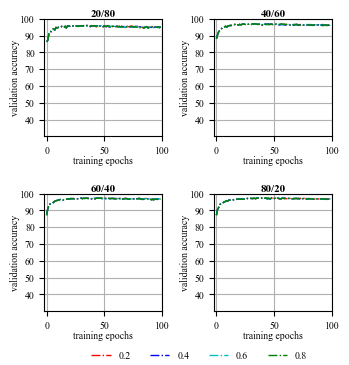

In [21]:
import pandas as pd
import matplotlib
font = {'family': 'Times New Roman',
        'size': 7}
font1 = {'family': 'Times New Roman',
         'size': 7}

matplotlib.rc('font', **font)
c = 2
trust_props = [0.2, 0.4, 0.6, 0.8]
noise_levels = [0.2, 0.4, 0.6, 0.8]
max_epochs = 100
fig, axs = plt.subplots(2, 2, figsize=(3.5, 3.6), tight_layout=True)

max_val_accs = np.zeros([len(trust_props), len(noise_levels)])
max_test_accs = np.zeros([len(trust_props), len(noise_levels)])

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

testset = MNIST(root='./data', split='test',download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=512, shuffle=False, num_workers=0)
unique_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# G: \My Drive\Research Codes\Subset Selection Paper\Neural Network Classifier\USPS\CIFAR10\test on noisy data\Lambda tests\ss_1 cifar10 c = 20trust_prop = 0.40noise_level = 0.20.pth

models_path = ""

line_colors = ['r', 'b', 'c', 'g']
for i in range(len(trust_props)):
    for j in range(len(noise_levels)):
        trust_prop = trust_props[i]
        noise_level = noise_levels[j]
        net_path = models_path + "ss_1 " +  "mnist " + "c={cs:2d}".format(cs=c)+"trust_prop={trust_prop:0.2f}".format(trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
        best_net_dict = torch.load(net_path)
        net = MNIST_classifier().to(device)
        net.load_state_dict(best_net_dict['model_state_dict'])

        classes = tuple([str(i) for i in unique_labels])
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}
        total = 0
        correct = 0

        net.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels, _, _, _ = data
                outputs, _ = net(images.double().to(device))
                _, predictions = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predictions.cpu() == labels).sum().item()
            print(f'test set accuraccy: {100 * correct / total} %')
        max_test_accs[i, j] = 100 * correct / total

        acc_ci = best_net_dict["val-accuracy"]
        max_val_accs[i, j] = max(acc_ci)
        acc_ci = np.array([i/100 for i in acc_ci])
        iters = np.linspace(0, max_epochs, 100, endpoint=False)
        # label_str = "{trust_prop:0.0f}%".format(trust_prop=int(100*trust_prop)) + " {noise_level:0.1f}".format(noise_level=noise_level)
        label_str = "{noise_level:0.1f}".format(noise_level=noise_level)
        if i != len(trust_props)-1:
            axs.flatten()[i].plot(iters, 100*acc_ci,
                                  color=line_colors[j], linestyle="-.", linewidth=1.0)
        else:
            axs.flatten()[i].plot(iters, 100*acc_ci, color=line_colors[j],
                                  linestyle="-.", label=label_str, linewidth=1.0)

    title_str = str(int(100*trust_prop)) + "/" + str(int(100 - 100*trust_prop))
    axs.flatten()[i].set_title(title_str, font={
        'weight': 'bold', 'size': 8}, pad=0)
    axs.flatten()[i].set_xlabel("training epochs", labelpad=0.01, **font)
    axs.flatten()[i].set_ylabel("validation accuracy", labelpad=0.01, **font)
    axs.flatten()[i].set_xlim([-2, 100])
    axs.flatten()[i].set_yticks([40, 50, 60, 70, 80, 90, 100])
    axs.flatten()[i].set_ylim([30, 100])
    axs.flatten()[i].grid()
    axs.flatten()[i].set_box_aspect(1)
    # axs.flatten()[i].legend(ncol=1, prop =font1)
fig.legend(loc=(0.25, 0.001), prop=font1, ncol=4, frameon=False)
# fig.tight_layout()
max_val_accs_df = pd.DataFrame(max_val_accs, index=[int(100*i) for i in trust_props], columns=noise_levels)
max_test_accs_df = pd.DataFrame(max_test_accs, index=[int(100*i) for i in trust_props], columns=noise_levels)


In [22]:
max_test_accs_df


,0.2,0.4,0.6,0.8
20,95.76,95.94,95.71,95.84
40,97.05,96.96,97.14,97.03
60,97.39,97.64,97.44,97.45
80,97.26,97.27,97.38,97.40


test set accuraccy: 96.04 %
test set accuraccy: 95.76 %
test set accuraccy: 96.08 %
test set accuraccy: 96.09 %
test set accuraccy: 97.12 %
test set accuraccy: 96.91 %
test set accuraccy: 97.13 %
test set accuraccy: 97.01 %
test set accuraccy: 97.66 %
test set accuraccy: 97.5 %
test set accuraccy: 97.43 %
test set accuraccy: 97.55 %
test set accuraccy: 97.62 %
test set accuraccy: 97.61 %
test set accuraccy: 97.72 %
test set accuraccy: 97.42 %


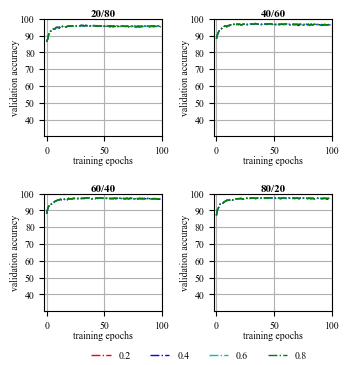

In [23]:
import pandas as pd
import matplotlib
font = {'family': 'Times New Roman',
        'size': 7}
font1 = {'family': 'Times New Roman',
         'size': 7}

matplotlib.rc('font', **font)
c = 20
trust_props = [0.2, 0.4, 0.6, 0.8]
noise_levels = [0.2, 0.4, 0.6, 0.8]
max_epochs = 100
fig, axs = plt.subplots(2, 2, figsize=(3.5, 3.6), tight_layout=True)

max_val_accs = np.zeros([len(trust_props), len(noise_levels)])
max_test_accs = np.zeros([len(trust_props), len(noise_levels)])

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

testset = MNIST(root='./data', split='test',
                  download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=512, shuffle=False, num_workers=0)
unique_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# G: \My Drive\Research Codes\Subset Selection Paper\Neural Network Classifier\USPS\CIFAR10\test on noisy data\Lambda tests\ss_1 cifar10 c = 20trust_prop = 0.40noise_level = 0.20.pth

models_path = ""

line_colors = ['r', 'b', 'c', 'g']
for i in range(len(trust_props)):
    for j in range(len(noise_levels)):
        trust_prop = trust_props[i]
        noise_level = noise_levels[j]
        net_path = models_path + "ss_1 " +  "mnist " + "c={cs:2d}".format(cs=c)+"trust_prop={trust_prop:0.2f}".format(trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
        best_net_dict = torch.load(net_path)
        net = MNIST_classifier().to(device)
        net.load_state_dict(best_net_dict['model_state_dict'])

        classes = tuple([str(i) for i in unique_labels])
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}
        total = 0
        correct = 0

        net.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels, _, _, _ = data
                outputs, _ = net(images.double().to(device))
                _, predictions = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predictions.cpu() == labels).sum().item()
            print(f'test set accuraccy: {100 * correct / total} %')
        max_test_accs[i, j] = 100 * correct / total

        acc_ci = best_net_dict["val-accuracy"]
        max_val_accs[i, j] = max(acc_ci)
        acc_ci = np.array([i/100 for i in acc_ci])
        iters = np.linspace(0, max_epochs, 100, endpoint=False)
        # label_str = "{trust_prop:0.0f}%".format(trust_prop=int(100*trust_prop)) + " {noise_level:0.1f}".format(noise_level=noise_level)
        label_str = "{noise_level:0.1f}".format(noise_level=noise_level)
        if i != len(trust_props)-1:
            axs.flatten()[i].plot(iters, 100*acc_ci,
                                  color=line_colors[j], linestyle="-.", linewidth=1.0)
        else:
            axs.flatten()[i].plot(iters, 100*acc_ci, color=line_colors[j],
                                  linestyle="-.", label=label_str, linewidth=1.0)

    title_str = str(int(100*trust_prop)) + "/" + str(int(100 - 100*trust_prop))
    axs.flatten()[i].set_title(title_str, font={
        'weight': 'bold', 'size': 8}, pad=0)
    axs.flatten()[i].set_xlabel("training epochs", labelpad=0.01, **font)
    axs.flatten()[i].set_ylabel("validation accuracy", labelpad=0.01, **font)
    axs.flatten()[i].set_xlim([-2, 100])
    axs.flatten()[i].set_yticks([40, 50, 60, 70, 80, 90, 100])
    axs.flatten()[i].set_ylim([30, 100])
    axs.flatten()[i].grid()
    axs.flatten()[i].set_box_aspect(1)
    # axs.flatten()[i].legend(ncol=1, prop =font1)
fig.legend(loc=(0.25, 0.001), prop=font1, ncol=4, frameon=False)
# fig.tight_layout()
max_val_accs_df = pd.DataFrame(max_val_accs, index=[int(100*i) for i in trust_props], columns=noise_levels)
max_test_accs_df = pd.DataFrame(max_test_accs, index=[int(100*i) for i in trust_props], columns=noise_levels)


In [24]:
max_test_accs_df


,0.2,0.4,0.6,0.8
20,96.04,95.76,96.08,96.09
40,97.12,96.91,97.13,97.01
60,97.66,97.50,97.43,97.55
80,97.62,97.61,97.72,97.42
